## Imports

In [94]:
import glob
import cv2
import json
import time
import numpy as np
from PIL import ImageColor
from numba import jit

import scipy.io as sio
from scipy import io

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

#### Create masks from annotations and create mat files

- Read images
- Read annotation for each image
- Create mask for annotation
- Create mat file from annotation

In [95]:
# define some variables
image_path = './images/'
annotation_path = './annotation/json/'
annotation_path_mat = './annotation/mat/'

# list of files in directory
image_list = glob.glob(image_path + '*.*')



f_goal = open(f"./cam_4_dataset/annotation/static_annotations/Goal.json")
data_goal = json.load(f_goal)
f_doellijn = open(f"./cam_4_dataset/annotation/static_annotations/Doellijn.json")
data_doellijn = json.load(f_doellijn)


color_doellijn = (255,0,0)
color_goal = (0,255,0)
static_labels = [{'label': 'Doellijn', 'color': color_doellijn, 'annotations': data_doellijn},{'label': 'Goal', 'color': color_goal, 'annotations': data_goal}]


color_bal = (0,0,255)
labels_colors = [{'label': 'Bal', 'color': color_bal}]

color_background = (240,0,240)

In [96]:
image_annotations = []

for image in image_list:
    image_name = image.split('\\')[1].split('.')[0]
    img = cv2.imread(image)

    f = open(annotation_path + f"{image_name}.json")
    data = json.load(f)

    obj = {
        'image_name': image_name,
        'image': img,
        'annotations': data
    }

    image_annotations.append(obj)


In [97]:
def get_color(labelname):
    return [lc['color'] for lc in labels_colors if lc['label'] == labelname]

In [98]:
# testing with one file
ia = image_annotations[15]
image = ia['image']
annotations = ia['annotations']['annotations']

start_time = time.time()
img = np.zeros((1080, 1920, 3), dtype = "uint8")
img[:] = color_background
img_new = None
for annotation in annotations:

    for ann in annotation:

        if 'polygonlabels' in ann['value']:
            lb = ann['value']['polygonlabels'][0]
            sl = [label['label'] for label in static_labels]
            if lb not in static_labels:
                # draw the polygon
                points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in ann['value']['points']]

                h = get_color(lb)[0]

                pts = np.array(points, np.int32)

                img_new = cv2.fillPoly(img, [pts], h)

for static in static_labels:
    points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in static['annotations']['value']['points']]


    pts = np.array(points, np.int32)
    img_new = cv2.fillPoly(img, [pts], static['color'])

cv2.imshow('Polygon', img_new)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [99]:
# apply to all images and add to list
masks = []
for ia in image_annotations: 
    image_name = ia['image_name']
    image = ia['image']
    annotations = ia['annotations']['annotations']

    start_time = time.time()
    img = np.zeros((1080, 1920, 3), dtype = "uint8")
    img[:] = color_background
    
    img_new = None
    for annotation in annotations:

        for ann in annotation:

            if 'polygonlabels' in ann['value']:
                lb = ann['value']['polygonlabels'][0]
                sl = [label['label'] for label in static_labels]
                if lb not in static_labels:
                    # draw the polygon
                    points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in ann['value']['points']]
                    try:
                        h = get_color(lb)[0]
                        pts = np.array(points, np.int32)
                        img_new = cv2.fillPoly(img, [pts], h)

                    except:
                        pass

    # for static in static_labels:
    #     points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in static['annotations']['value']['points']]


    #     pts = np.array(points, np.int32)
    #     img_new = cv2.fillPoly(img, [pts], static['color'])
    
    masks.append((image_name,img))

In [100]:
@jit # precompile to make function
def image_to_pixel_class(image):
    new_col = []
    for col in image:
        new_row = []
        for row in col:
            pixel_color = (row[0], row[1], row[2])
            if pixel_color == color_bal:
                new_row.append(1)
            elif pixel_color == color_doellijn:
                new_row.append(2)
            elif pixel_color == color_goal:
                new_row.append(3)
            else:
                new_row.append(0)
        new_col.append(new_row)
    return new_col

In [101]:
# set url to where mat files should be stored
url_mat = './annotation/mat/'

In [102]:
# test reading pixels from single image opencv

start_time = time.time()
image_class_pixel = image_to_pixel_class(masks[20][1])

sio.savemat('test.mat', {'groundtruth':image_class_pixel}, oned_as='column')

print(f"time: {time.time() - start_time} s")

time: 0.3769981861114502 s


In [103]:
start_time = time.time()
for mask in masks:
    image_class_pixel = image_to_pixel_class(mask[1])
    sio.savemat(url_mat + mask[0] + '.mat', {'groundtruth':image_class_pixel}, oned_as='column')
print(f"time: {time.time() - start_time} s")

time: 22.136265754699707 s


#### Read image and annotation files

In [104]:
images = []
for image in glob.glob('./images/*.*'):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

In [105]:
masks = []
for m in glob.glob('./annotation/mat/*.mat'):
    file = io.loadmat(m)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [106]:
len(images), len(masks)

(125, 125)

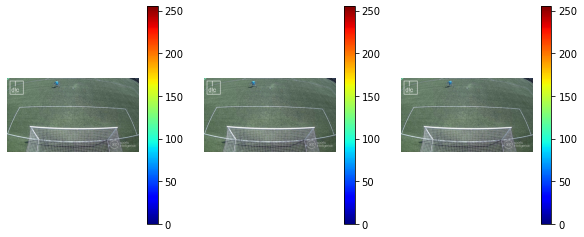

In [107]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

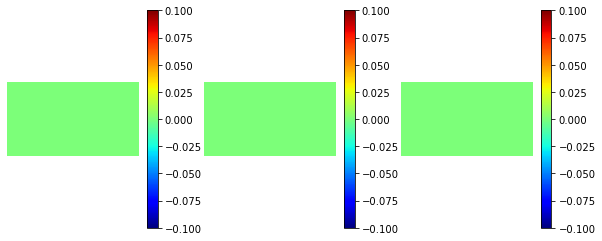

In [108]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [109]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 0)

#### Create deep learning model

In [110]:
base = keras.applications.DenseNet121(input_shape=[128,128,3], include_top=False, weights='imagenet')

In [111]:
len(base.layers)

427

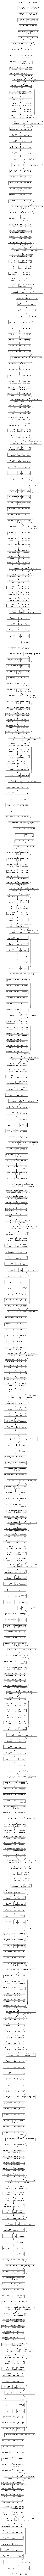

In [112]:
keras.utils.plot_model(base, show_shapes=True)

In [113]:
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ] 
              
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [114]:
downstack = keras.Model(inputs=base.input,
                        outputs=skip_outputs)
downstack.trainable = False

In [115]:
from tensorflow_examples.models.pix2pix import pix2pix
 # Four upstack blocks for upsampling sizes 
 # 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
        pix2pix.upsample(256,3),
        pix2pix.upsample(128,3),
        pix2pix.upsample(64,3)] 
upstack[0].layers

In [116]:
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])
# downsample 
down = downstack(inputs)
out = down[-1]
# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8
# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                strides=2,
                                padding='same',
                                )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

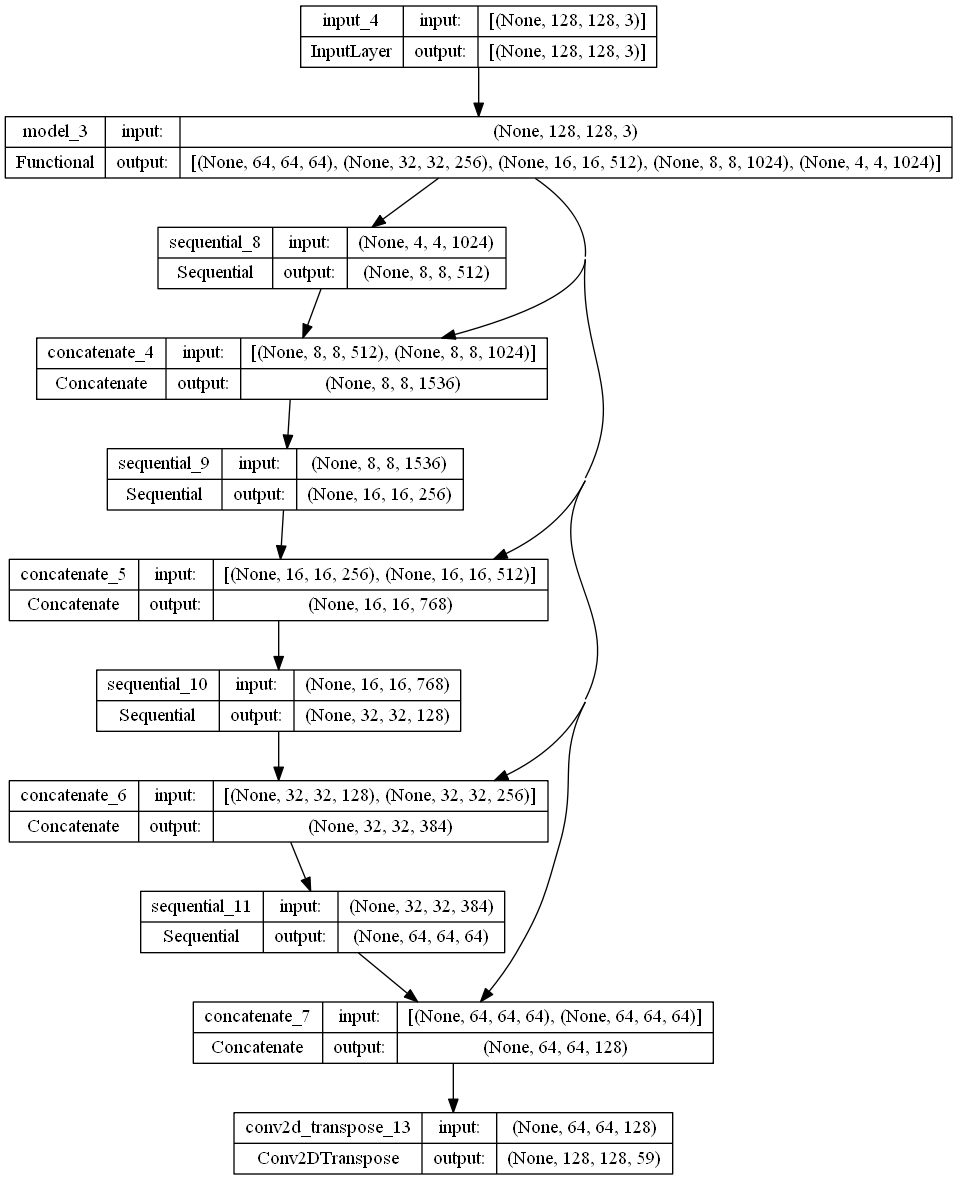

In [117]:
keras.utils.plot_model(unet, show_shapes=True)

In [118]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image / 255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [119]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

In [120]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                    test_size=0.2, 
                                                    random_state=0
                                                    )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [121]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [122]:
def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask 

In [123]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [124]:
# perform augmentation on train data only
a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [125]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

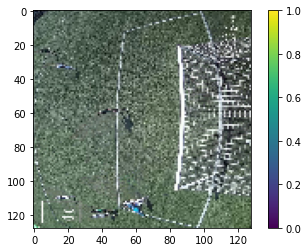

In [126]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

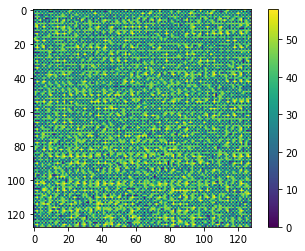

In [127]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

In [128]:
unet.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
             metrics=['accuracy']) 

hist = unet.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=50) 

Epoch 1/50
12/12 [==============================] - 41s 3s/step - loss: 2.5978 - accuracy: 0.8124 - val_loss: 2.0517 - val_accuracy: 0.9998
Epoch 2/50
12/12 [==============================] - 37s 3s/step - loss: 1.0795 - accuracy: 0.9998
Epoch 3/50
12/12 [==============================] - 37s 3s/step - loss: 0.5577 - accuracy: 0.9998
Epoch 4/50
12/12 [==============================] - 37s 3s/step - loss: 0.3084 - accuracy: 0.9998
Epoch 5/50
12/12 [==============================] - 38s 3s/step - loss: 0.1751 - accuracy: 0.9998
Epoch 6/50
12/12 [==============================] - 38s 3s/step - loss: 0.0996 - accuracy: 0.9998
Epoch 7/50
12/12 [==============================] - 38s 3s/step - loss: 0.0563 - accuracy: 0.9998
Epoch 8/50
12/12 [==============================] - 37s 3s/step - loss: 0.0327 - accuracy: 0.9998
Epoch 9/50
12/12 [==============================] - 38s 3s/step - loss: 0.0194 - accuracy: 0.9998
Epoch 10/50
12/12 [==============================] - 38s 3s/step - loss: 0.0

1/1 [==============================] - 2s 2s/step


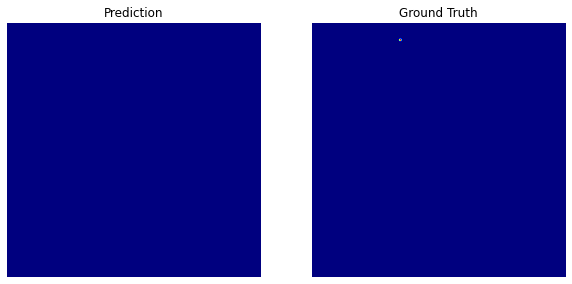

In [129]:

for img, mask in iter(val):

    pred = unet.predict(img)

    plt.figure(figsize=(10,5))
    for i in pred:
        plt.subplot(121)
        i = tf.argmax(i, axis=-1)
        plt.imshow(i,cmap='jet')
        plt.axis('off')
        plt.title('Prediction')
        break

    plt.subplot(122)
    plt.imshow(mask[0], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')
    plt.show()

[0.9997656345367432]


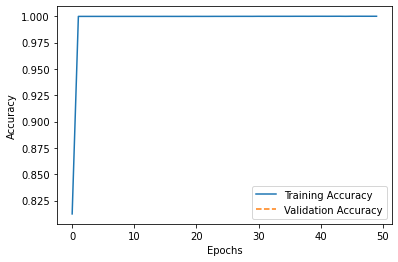

In [130]:
history = hist.history
print(history['val_accuracy'])
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()